In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyFTS.common import Util
from pyFTS.common import Transformations
from statsmodels.tsa.stattools import acf

In [2]:
data_url = 'https://raw.githubusercontent.com/ZiggerZZ/taxitime/master/data/complete_data.csv'
df = pd.read_csv( data_url )
df['actual_landing_time'] = pd.to_datetime( df.actual_landing_time )
df['date'] = pd.to_datetime( df.date )

tdiff = Transformations.Differential(1)
df_diff = tdiff.apply( np.array( df.t_minutes ) )

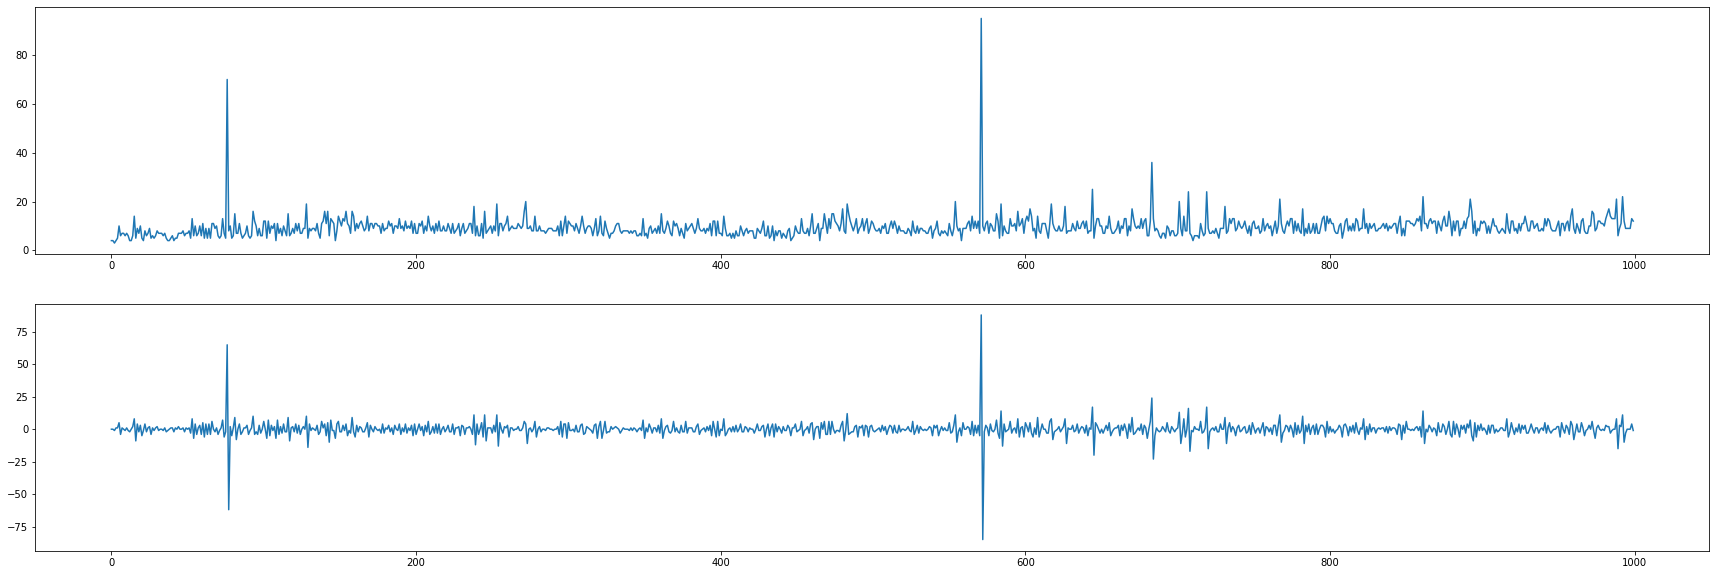

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize= (30,10))

ax[0].plot( df.t_minutes[:1_000] )
ax[1].plot( df_diff[:1_000] )

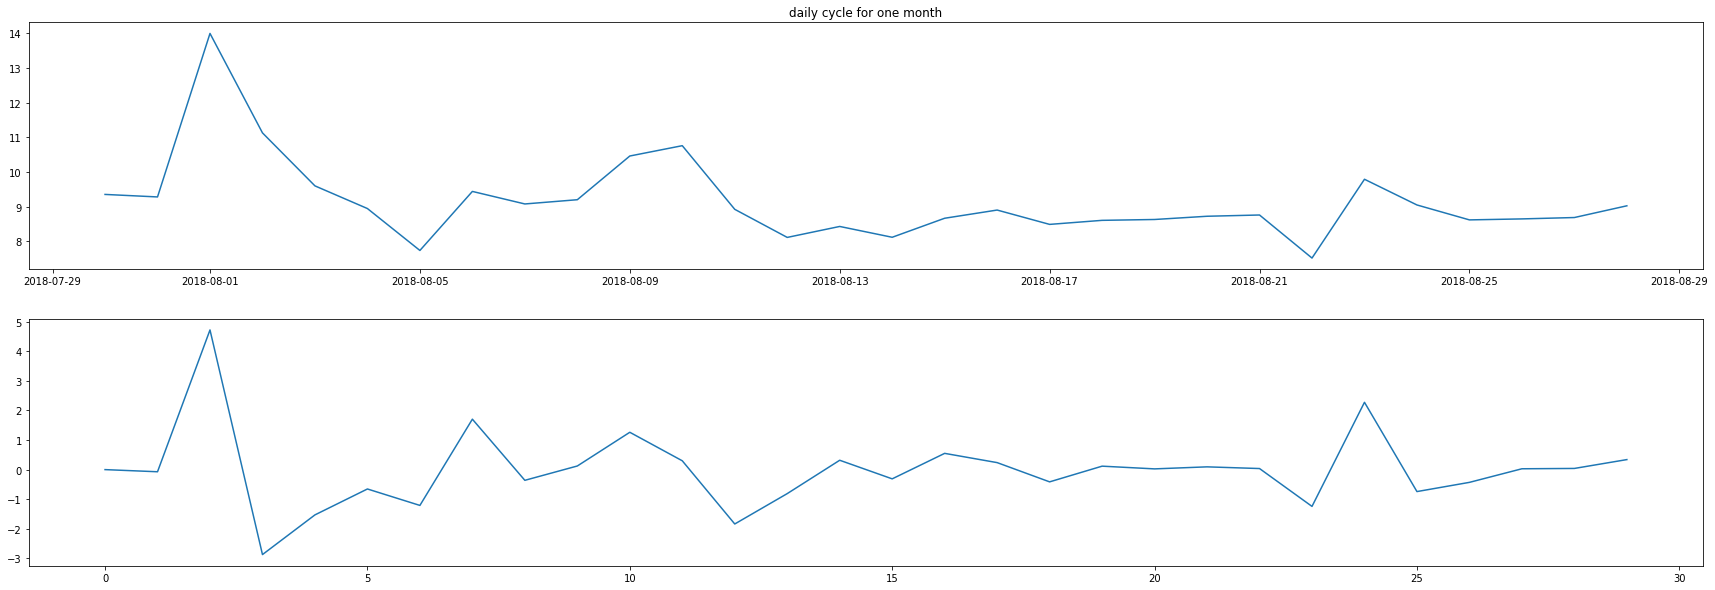

In [4]:
# Averaging per day
daily = df.loc[:, ['date', 't_minutes'] ].groupby( ['date'] ).mean()
daily_diff = tdiff.apply( np.array( daily.t_minutes ) )

fig, ax = plt.subplots(nrows=2, ncols=1,figsize= (30,10))
ax[0].set_title("daily cycle for one month")
ax[0].plot( daily.t_minutes[:30] )
ax[1].plot( daily_diff[:30] )

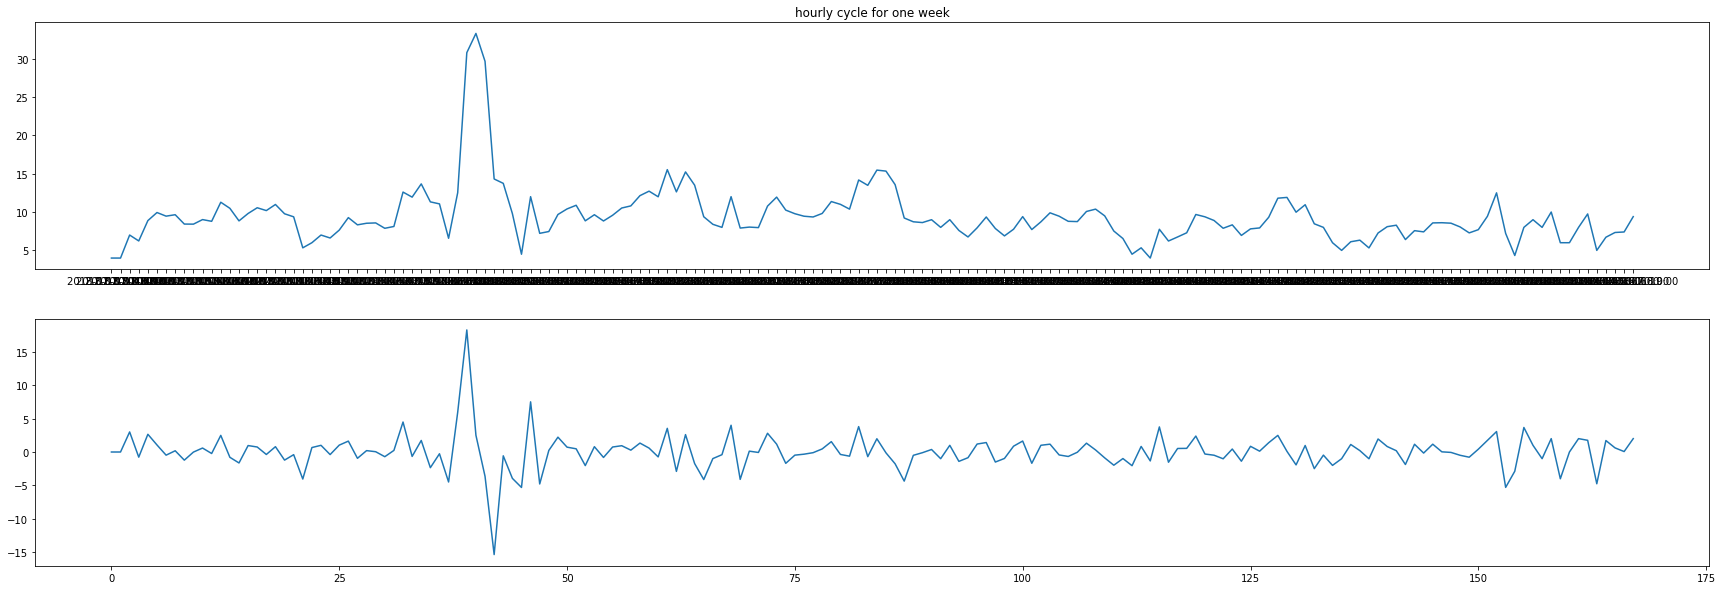

In [5]:
# Averaging per hour
df['date_hour'] = df.actual_landing_time.apply( lambda x:x.strftime('%Y-%m-%d %H:00') )

hourly = df.loc[:, ['date_hour', 't_minutes'] ].groupby( ['date_hour'] ).mean()
hourly_diff = tdiff.apply( np.array( hourly.t_minutes ) )

fig, ax = plt.subplots(nrows=2, ncols=1,figsize= (30,10))
ax[0].set_title("hourly cycle for one week")
ax[0].plot( hourly.t_minutes[:168] )
ax[1].plot( hourly_diff[:168] )

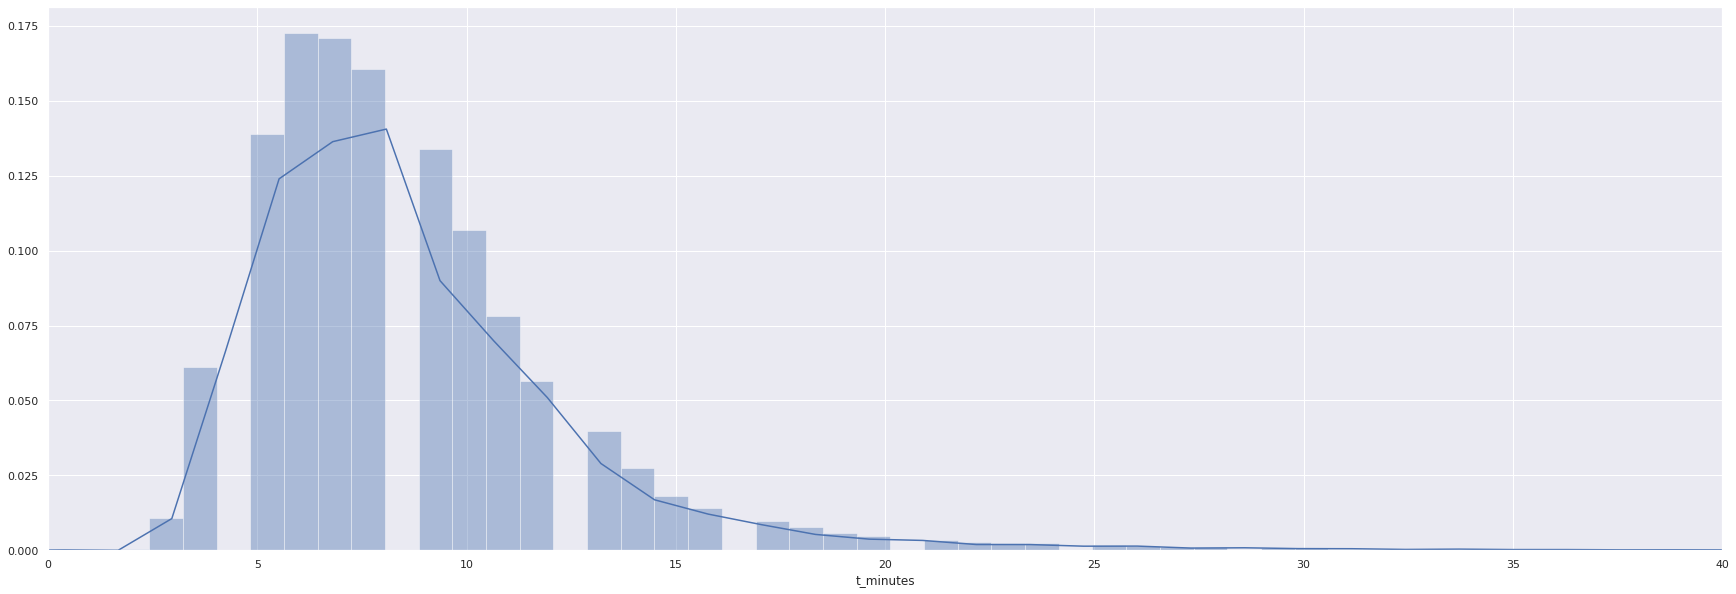

In [6]:
import seaborn as sns

sns.set(color_codes=True)
fig = plt.figure( figsize= (30,10))
plt.xlim(right= 40) 

sns.distplot(a= df.t_minutes, bins= 200);

In [7]:
import math

df = df.loc[ df['t_minutes']>0 ]
df['log_t_minutes'] = df.t_minutes.apply( math.log )

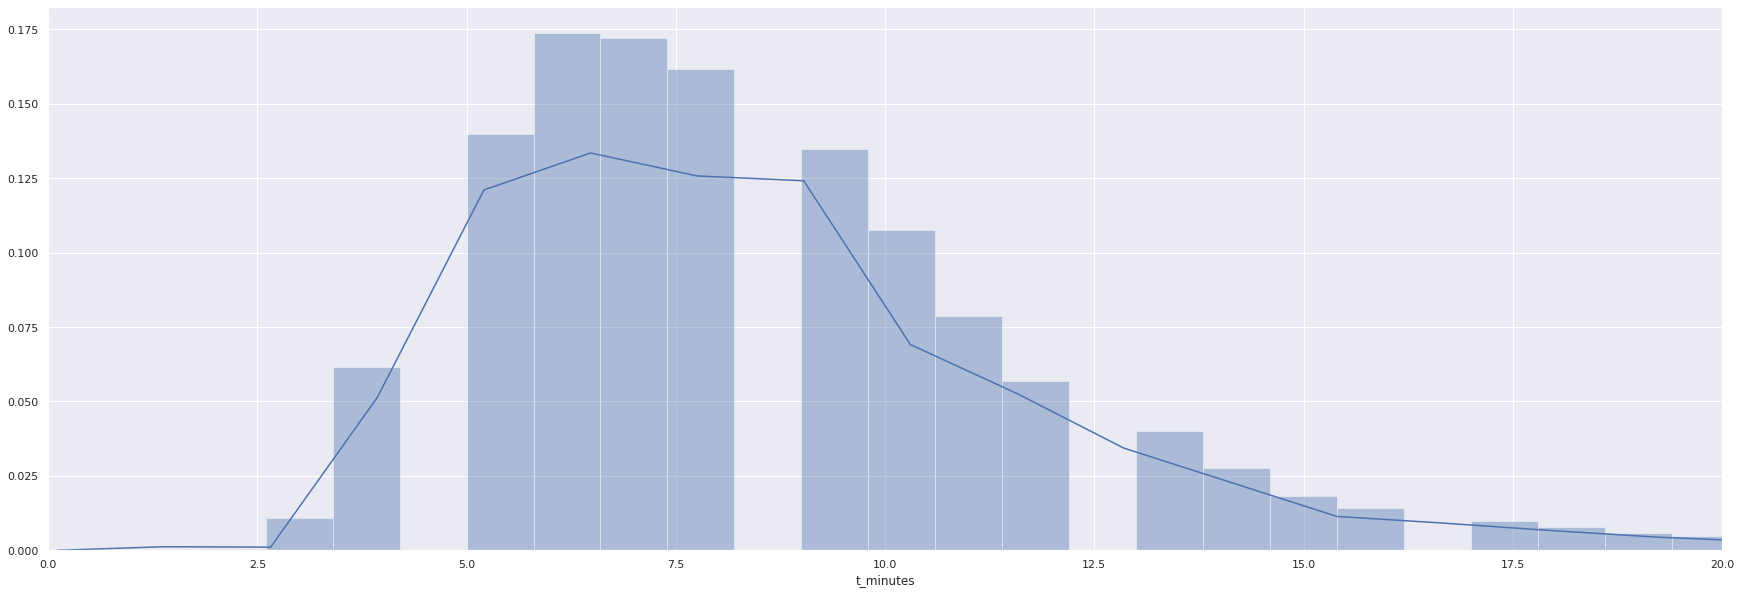

In [8]:
fig = plt.figure( figsize= (30,10))
plt.xlim(right= 20) 

sns.distplot(a= df.t_minutes, bins= 200);

In [9]:
df.t_minutes.describe()

count    134051.000000
mean          8.781136
std           4.695250
min           1.000000
25%           6.000000
50%           8.000000
75%          10.000000
max         161.000000
Name: t_minutes, dtype: float64

In [10]:
df.log_t_minutes.describe()

count    134051.000000
mean          2.082291
std           0.404800
min           0.000000
25%           1.791759
50%           2.079442
75%           2.302585
max           5.081404
Name: log_t_minutes, dtype: float64

Text(0.5, 0, 'LAG')

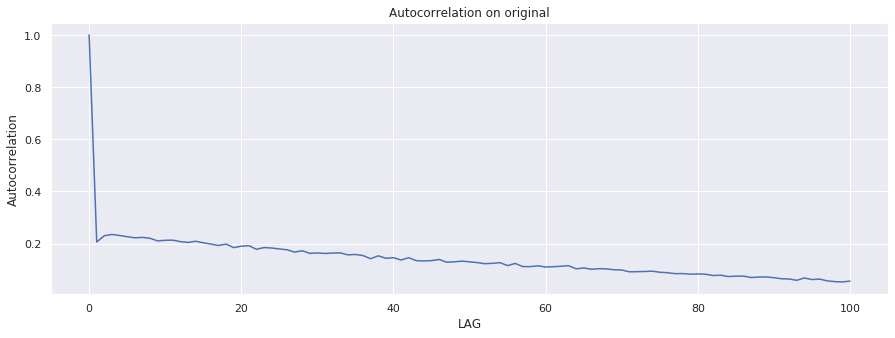

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot( acf( df.t_minutes,nlags=100) )
ax.set_title("Autocorrelation on original")
ax.set_ylabel("Autocorrelation")
ax.set_xlabel("LAG")

Text(0.5, 0, 'LAG')

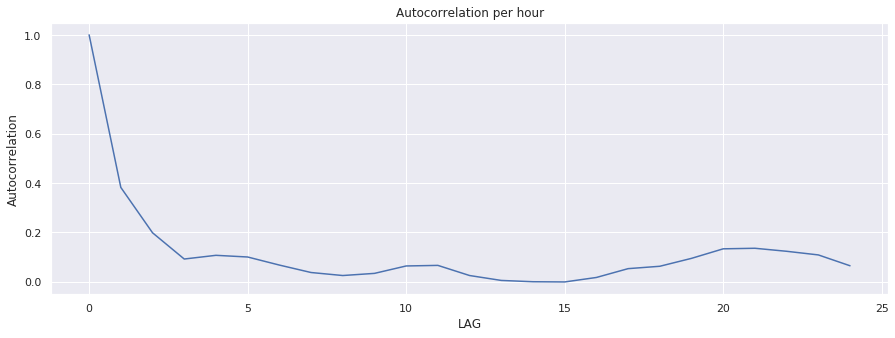

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot( acf( hourly.t_minutes,nlags=24) )
ax.set_title("Autocorrelation per hour")
ax.set_ylabel("Autocorrelation")
ax.set_xlabel("LAG")

Text(0.5, 0, 'LAG')

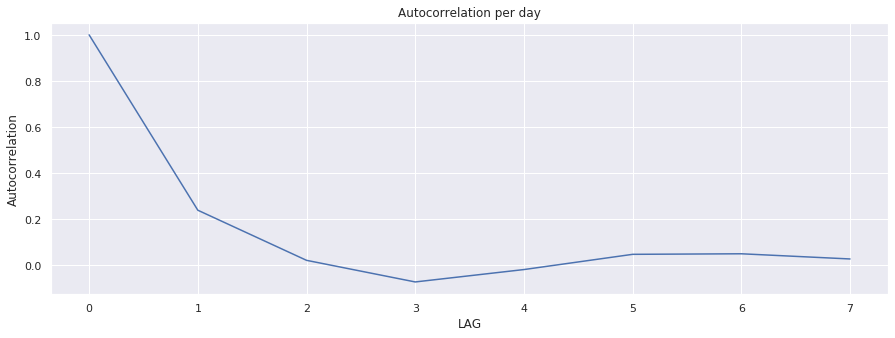

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot( acf( daily.t_minutes,nlags=7) )
ax.set_title("Autocorrelation per day")
ax.set_ylabel("Autocorrelation")
ax.set_xlabel("LAG")

### Fuzzy Time Series

In [16]:
from pyFTS.partitioners import Grid
from pyFTS.models import hofts, pwfts
from pyFTS.benchmarks import Measures
from itertools import product

In [18]:
# Split train - validation sets
train_ar = hourly.t_minutes.values[ : int(.8*hourly.shape[0]) ]
valid_ar = hourly.t_minutes.values[ int(.8*hourly.shape[0]) : ]

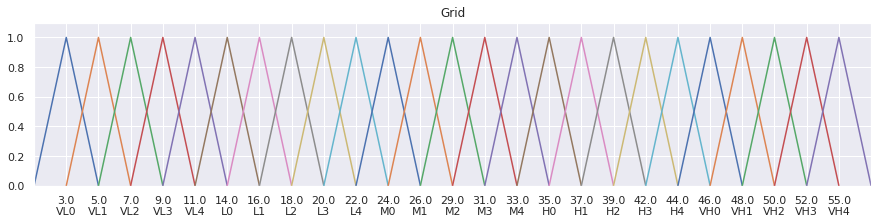

In [165]:
levels = ['VL','L','M','H','VH']
sublevels = [str(k) for k in np.arange(0,5)]
names = []
for combination in product(*[levels, sublevels]):
    names.append(combination[0]+combination[1])


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])
part = Grid.GridPartitioner(data= train_ar, npart=25, names= names)
part.plot(ax)

In [169]:
%%time
model = pwfts.ProbabilisticWeightedFTS(partitioner=part, order= 2)
model.fit( train_ar )
forecasts = model.predict( valid_ar )
rmse,_,_ = Measures.get_point_statistics( valid_ar, model)

print( f"Model: {model.name} \nOrder: {model.order} \nSize: {len(model)} \nRMSE: {rmse}",  '\n' )

Model: Probabilistic FTS 
Order: 2 
Size: 139 
RMSE: 2.6 

CPU times: user 5.44 s, sys: 43 ms, total: 5.48 s
Wall time: 5.45 s


    | partitions | order | rmse |
    =====================
    |    100     |   2   | 2.66 |
    |    50      |   2   | 2.61 |
    |    25      |   2   | 2.6  |
    |    25      |   3   | 2.63 |
    |    25      |   1   | 2.69 |

In [170]:
for x,y in zip( [0,0]+forecasts[:8] , valid_ar[:10] ):
    print(f"Prediction: {x}", f"Actuals: {y}")

Prediction: 0 Actuals: 8.67741935483871
Prediction: 0 Actuals: 6.594594594594595
Prediction: 7.895161673402377 Actuals: 6.025
Prediction: 7.623556115549772 Actuals: 6.490566037735849
Prediction: 7.657005299395027 Actuals: 5.411764705882353
Prediction: 7.439408663060755 Actuals: 8.285714285714286
Prediction: 8.012228563329659 Actuals: 8.31578947368421
Prediction: 8.46669263271354 Actuals: 9.46
Prediction: 8.853898556742301 Actuals: 10.980392156862745
Prediction: 9.517942046824148 Actuals: 10.833333333333334


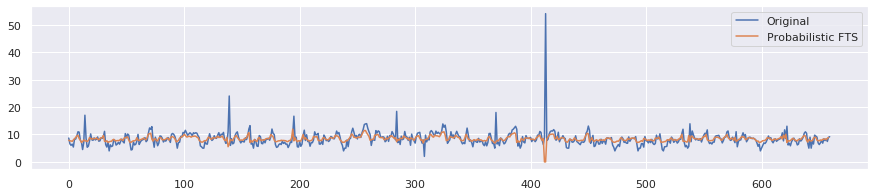

In [171]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])
ax.plot(valid_ar[:1_000], label='Original')
ax.plot(forecasts[:1_000], label=model.name)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=1)

### Test model

In [172]:
# TEST DATASET
test_url = 'https://raw.githubusercontent.com/ZiggerZZ/taxitime/master/data/test_complete_data.csv'
test_data = pd.read_csv( test_url )

In [173]:
from datetime import datetime
test_data = test_data[['actual_landing_time', 't_minutes']]
test_data['actual_landing_time'] = pd.to_datetime( test_data.actual_landing_time )
test_data['date_hour'] = test_data.actual_landing_time.apply( lambda x: datetime.strptime(x.strftime('%Y-%m-%d %H:00'), '%Y-%m-%d %H:00') )

test_data.head()

,actual_landing_time,t_minutes,date_hour
0,2019-01-17 03:18:00,5.0,2019-01-17 03:00:00
1,2019-01-17 03:36:00,7.0,2019-01-17 03:00:00
2,2019-01-17 03:44:00,5.0,2019-01-17 03:00:00
3,2019-01-17 03:49:00,5.0,2019-01-17 03:00:00
4,2019-01-17 03:50:00,8.0,2019-01-17 03:00:00


In [174]:
# Calculate range of hours = the number of points to predict
steps = int((test_data.date_hour.max() - test_data.date_hour.min()).total_seconds()//3600)
# Get 3 earlierst hourly averages for the time-series to begin (Order 3) 
initial_points = np.array( test_data.groupby('date_hour')['t_minutes'].mean()[:3] ) 

In [175]:
from datetime import timedelta

# Make a list with all the 'date_hours' in the test interval
earliest = test_data.date_hour.min()
hours = [earliest + timedelta(hours=i) for i in range(steps)]
# predict the time-series
hourly_prediction =  model.predict( data= initial_points, steps_ahead= steps )

# Wrap everything into a dataframe
pred_data = pd.DataFrame( zip(hours, hourly_prediction), columns= ['date_hour', 'prediction'] )
pred_data.head()

,date_hour,prediction
0,2019-01-17 03:00:00,7.585955
1,2019-01-17 04:00:00,7.869502
2,2019-01-17 05:00:00,8.138972
3,2019-01-17 06:00:00,8.306482
4,2019-01-17 07:00:00,8.433047


In [176]:
# INNER JOIN to the test dataset to get actuals with predictions together
test_data = pd.merge(test_data, pred_data, on='date_hour', how='inner')
test_data.head()

,actual_landing_time,t_minutes,date_hour,prediction
0,2019-01-17 03:18:00,5.0,2019-01-17 03:00:00,7.585955
1,2019-01-17 03:36:00,7.0,2019-01-17 03:00:00,7.585955
2,2019-01-17 03:44:00,5.0,2019-01-17 03:00:00,7.585955
3,2019-01-17 03:49:00,5.0,2019-01-17 03:00:00,7.585955
4,2019-01-17 03:50:00,8.0,2019-01-17 03:00:00,7.585955


In [177]:
# Calculate the Root Mean Square Error
rmse = lambda prediction, actual: (((prediction - actual) ** 2).mean())**(1/2)

rmse(test_data.t_minutes, test_data.prediction)

4.921068342659638

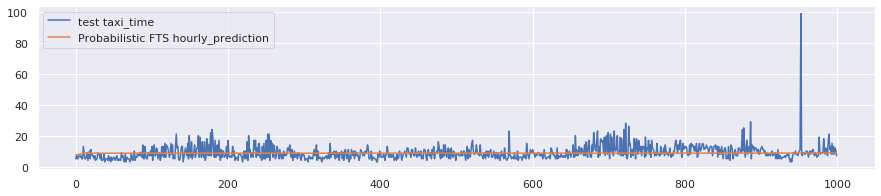

In [179]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])
ax.plot(test_data.t_minutes[:1_000], label= 'test taxi_time')
ax.plot(test_data.prediction[:1_000], label= model.name+' hourly_prediction')

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2)